# Using Decision Trees to Explain how Bayern Munich went from "Transitioning" into "UCL Title Contender"

Bayern Munich had a lot of questions coming into this season, and the club's immediate future success was not a given like most years. With last year's Bundesliga title not being clinched until the final matchday, the record signing Lucas Hernandez returning from an extended injury leave, and the superfluous drama around the Leroy Sane saga, the one thing that would bring the club and its fans back to normal was some consistent success the club had enjoyed for the better part of the decade. 

This did not happen, however. 10 games into the second Bundesliga season with Niko Kovac as manager, Bayern found themselves 4th in the table, 4 points behind the leaders Borussia Monchengladbach. At some points during this stretch, Bayern looked unbeatable, such as in their 7-2 win over Tottenham in the Champions League. At other times, the team seemed mediocre, such as in their 5-1 loss against Frankfurt. On November 3rd, with important matches against Olympiacos and Borussia Dortmund coming up, Bayern sacked Niko Kovac and promoted then assistant manager Hansi Flick to be the interim manager until the club chose a permanent replacement.

Since then, Bayern have improved dramatically. With the Bundesliga season coming to its conclusion, Bayern have separated themselves from the pack as the best team in Germany once again, and are one of the favorites to win the Champions League once it resumes. 

How did this happen? How did the biggest club in Germany go from struggling to get back to their normal success, to dominating in such a way even the club itself has not been able to do in some time? Just by watching the team play, it is evident that multiple aspects of the squad have improved. 

I take my shot at answering this using data from matches to see what has changed between the beginning of the season and now and why all of this has occurred.

## Methodology

To do this, I retreived team data from fbref.com, a site that has a large amount of player and team data from matches. The data consists of Bundesliga and Champions League matches, since DFB-Pokal and DFL-Supercup matches do not have in depth match data. Using this data, a Random Forest Classification algorithm will be used to distinguish between matches that were managed by Niko Kovac and matches that were managed by Hansi Flick. Random Forest was chosen because a lot of the match statistics have discrete values, which makes cutoffs between data much easier.

## Data Import and Preprocessing

First, the required libraries are imported:

In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import tree

Next, the team data is imported. The data is divided up into different categories of statistics that are on the fbref.com website. These statistical categories are:

* Scores/overall match data
* Possession data
* Passing data
* Pass type data
* Shot creation data
* Shooting data
* Defensive data
* Goalkeeping data
* Misc data

These data categories were downloaded as csv files and imported below:

In [136]:
scores = pd.read_csv('data/Scores_Fixtures.csv')
misc = pd.read_csv('data/Misc_Stats.csv')
possession = pd.read_csv('data/Possession_Stats.csv')
defense = pd.read_csv('data/Defensive_Stats.csv')
shot_creation = pd.read_csv('data/Shots_Stats.csv')
pass_types = pd.read_csv('data/Pass_Type_Stats.csv', encoding = 'unicode_escape')
passing = pd.read_csv('data/Passing_Stats.csv')
goalkeeping = pd.read_csv('data/Goalkeeping_Stats.csv')
shooting = pd.read_csv('data/Shooting_Stats.csv')

Here's what a table looks like:

In [137]:
scores.head()

,Date,Comp,Venue,Result,GF,GA,Opponent,xG,xGA,Poss,Formation
0,8/3/2019,DFL-Supercup,Neutral,L,0.0,2.0,Dortmund,NaN,NaN,65.0,4-2-3-1
1,8/12/2019,DFB-Pokal,Away,W,3.0,1.0,Energie Cottbus,NaN,NaN,80.0,4/3/2003
2,8/16/2019,Bundesliga,Home,D,2.0,2.0,Hertha BSC,2.7,0.9,71.0,4/3/2003
3,8/24/2019,Bundesliga,Away,W,3.0,0.0,Schalke 04,1.6,0.9,66.0,4/3/2003
4,8/31/2019,Bundesliga,Home,W,6.0,1.0,Mainz 05,2.6,0.4,67.0,4-2-3-1


Some preprocessing needs to be done to make analysis of this data more efficient later on. It was first noticed that the bottom two rows on only some of the tables were all NaN values, so these needed to be dropped:

In [138]:
misc = misc.drop(misc.index[[-2,-1]])
possession = possession.drop(possession.index[[-2,-1]])
defense = defense.drop(defense.index[[-2,-1]])
shot_creation = shot_creation.drop(shot_creation.index[[-2,-1]])

Next, the dataframes will all be compiled into one array for efficient preprocessing:

In [139]:
team_stats = [scores, 
              possession, 
              passing, 
              pass_types, 
              shot_creation, 
              shooting, 
              defense, 
              goalkeeping, 
              misc]

The 'Date' column for each table is converted into a 'datetime' format so that it can be used as the index of each table later on:

In [140]:
for i in range(len(team_stats)):
    for j in range(team_stats[i].shape[0]):
        date = team_stats[i].iloc[j,0]
        date_dt = datetime.strptime(date,'%m/%d/%Y')
        team_stats[i].iloc[j,0] = date_dt

In [141]:
team_stats[0].head()

,Date,Comp,Venue,Result,GF,GA,Opponent,xG,xGA,Poss,Formation
0,2019-08-03 00:00:00,DFL-Supercup,Neutral,L,0.0,2.0,Dortmund,NaN,NaN,65.0,4-2-3-1
1,2019-08-12 00:00:00,DFB-Pokal,Away,W,3.0,1.0,Energie Cottbus,NaN,NaN,80.0,4/3/2003
2,2019-08-16 00:00:00,Bundesliga,Home,D,2.0,2.0,Hertha BSC,2.7,0.9,71.0,4/3/2003
3,2019-08-24 00:00:00,Bundesliga,Away,W,3.0,0.0,Schalke 04,1.6,0.9,66.0,4/3/2003
4,2019-08-31 00:00:00,Bundesliga,Home,W,6.0,1.0,Mainz 05,2.6,0.4,67.0,4-2-3-1


The date of each fixture is now in datetime form. Some miscellaneous preprocessing is shown below, with comments explaining each step:

In [142]:
#Remove 2nd leg of the UCL match against Chelsea
for i in range(len(team_stats)):
    index = []
    for j in range(team_stats[i].shape[0]):
        if team_stats[i].iloc[j,0].year == 2020:
            if team_stats[i].iloc[j,0].month == 3:
                if team_stats[i].iloc[j,0].day == 18:
                    index.append(j)
    team_stats[i] = team_stats[i].drop(team_stats[i].index[index])
    
#Remove DFB Pokal and DFB Supercup mathces
for i in range(len(team_stats)):
    indexes = []
    for j in range(team_stats[i].shape[0]):
        if team_stats[i].iloc[j,1] == 'DFL-Supercup':
            indexes.append(j)
        elif team_stats[i].iloc[j,1] == 'DFB-Pokal':
            indexes.append(j)
    team_stats[i] = team_stats[i].drop(team_stats[i].index[indexes])
    
#Change formations that are in date type
for i in range(team_stats[0].shape[0]):
    if team_stats[0].iloc[i,9] == '4/3/2003':
        team_stats[0].iloc[i,9] = '4-3-3'
    if team_stats[0].iloc[i,9] == '3/4/2003':
        team_stats[0].iloc[i,9] = '3-4-3'
        
#Some NaN values are in the Goalkeeping table for Save%.
#These will be converted to 1.0
nanvals = np.where(team_stats[7].isna())
for i in range(len(nanvals[0])):
    x = nanvals[0][i]
    y = nanvals[1][i]
    team_stats[7].iloc[x,y] = 1.0

The 'Date' column is used as the index for each table:

In [144]:
for i in range(len(team_stats)):
    team_stats[i] = team_stats[i].set_index('Date')

We are also going to use One-Hot Encoding on the 'Results' and 'Formation features, as these are valuable categorical features that we want to convert into numberic features for easier analysis:

In [145]:
onehot_features = ['Result', 'Formation']
not_onehot_features = ['Comp','Venue','GF','GA','Opponent','xG','xGA','Poss']
onehot_df = team_stats[0][onehot_features]
df_onehot = pd.get_dummies(onehot_df)
team_stats[0] = pd.concat([team_stats[0][not_onehot_features], 
                           df_onehot], axis=1)

It was noticed that some statistics repeat themselves in different tables. These will be removed so duplicates aren't in our final tables:

In [146]:
team_stats[3].drop('Day',axis=1,inplace=True)
team_stats[3].drop('Att',axis=1,inplace=True)
team_stats[3].drop('Cmp',axis=1,inplace=True)
team_stats[5].drop('Gls',axis=1,inplace=True)
team_stats[5].drop('xG',axis=1,inplace=True)
team_stats[7].drop('GA.1',axis=1,inplace=True)
team_stats[8].drop(['Off','Crs','Int','TklW'],axis=1,inplace=True)

The first few columns on each dataframe are the same; each table starts with the competition (Bundesliga or Champions League), the venue (Home or Away), the opponent, the result, the goals for, and the goals against. These will only be kept for the first table:

In [147]:
for i in range(len(team_stats)-1):
    team_stats[i+1].drop('Comp',axis=1,inplace=True)
    team_stats[i+1].drop('Venue', axis=1, inplace=True)
    team_stats[i+1].drop('Opponent', axis=1, inplace=True)
    team_stats[i+1].drop('Result', axis=1, inplace=True)
    team_stats[i+1].drop('GF', axis=1,inplace=True)
    team_stats[i+1].drop('GA',axis=1,inplace=True)

After initial data analysis, it became difficult to determine what each of the columns represented. Although this is a little brute force, it made analysis easier in the long run to rename most of the columns:

In [148]:
team_stats[0].rename(columns={'Poss':'Possession'})
team_stats[1].rename(columns={'Def Pen':'Touches Def_Pen','Def 3rd':'Touches Def_3rd','Mid 3rd':'Touches Mid_3rd','Att 3rd':'Touches Att_3rd','Att Pen':'Touches Att_Pen','Live':'Live Ball Touches','Succ':'Dribbles_Succ','Att':'Dribbles_Att','Succ%':'Dribbles Succ%','#Pl':'# Players Dribbled Past','Megs':'Nutmegs','TotDist':'TotDist Carried','PrgDist':'ProgDist Carried','Targ':'Pass Target Times','Rec':'Passes Received','Rec%':'Pass Received%','Miscon':'Miscontrols','Dispos':'Dispossessed'},inplace=True)
team_stats[2].rename(columns={'Cmp':'Passes_Cmp','Att':'Passes_Att','Cmp%':'Pass_Cmp%','TotDist':'Passes_TotDist','PrgDist':'Passes_PrgDist','Cmp.1':'ShortPass_Cmp','Att.1':'ShortPass_Att','Cmp%.1':'ShortPass_Cmp%','Cmp.2':'MedPass_Cmp','Att.2':'MedPass_Att','Cmp%.2':'MedPass_Cmp%','Cmp.3':'LongPass_Cmp','Att.3':'LongPass_Att','Cmp%.3':'LongPass_Cmp%','KP':'Key Passes','3-Jan':'Pass Into Final 1/3','PPA':'Passes Into Penalty Area','CrsPA':'Crosses Into Penalty Area','Prog':'Prog Passes'},inplace=True)
team_stats[3].rename(columns={'Live':'Live Passes','Dead':'Deadball Passes','FK':'FK Passes','TB':'Through Balls','Press':'Passes Under Pressure','Sw':'Switch Passes','Crs':'Crosses','CK':'Corner Kicks','In':'Inswinging CKs','Out':'Outswinging CKs','Str':'Straight CKs','Ground':'Ground Passes','Low':'Low Passes','High':'High Passes','Left':'Left-Foot Passes','Right':'Right-Foot Passes','Head':'Headed Passes','TI':'Throw Ins','Other':'Misc Passes','Off':'Offsides','Out.1':'Passes OOB','Int':'Passes Intercepted','Blocks':'Passes Blocked'},inplace=True)
team_stats[4].rename(columns={'SCA':'Shot Creating Actions','PassLive':'Live Passes to Shot','PassDead':'Dead Passes to Shot','Drib':'Dribbles to Shot','Sh':'Shots lead to another shot','Fld':'Fouls leading to shot','GCA':'Goal Creating Actions','PassLive.1':'Live Passes to Goal','PassDead.1':'Dead Passes to Goal','Drib.1':'Dribbles Leading to Goal','Sh.1':'Shots leading to a goal','Fld.1':'Fouls leading to goal','OG':'Own Goals Won'},inplace=True)
team_stats[5].rename(columns={'PK':'PKs Made','Pkatt':'PKs Att','Sh':'Shots','FK':'FK Shots','npxG':'non-penalty xG','npxG/Sh':'non-penalty xG/Sh','np:G-xG':'non-penalty G-xG'},inplace=True)
team_stats[6].rename(columns={'Tkl':'Tackles','TklW':'Tackles Won','Def 3rd':'Tackles Def_3rd','Mid 3rd':'Tackles Mid_3rd','Att 3rd':'Tackles Att_3rd','Tkl.1':'Dribblers Tackled','Att':'Dribbles Contested','Tkl%':'Dribblers Tackled%','Past':'Dribbled Past','Press':'Pressures','Succ':'Successful Pressures','%':'Succ Pressure%','Def 3rd.1':'Pressures Def_3rd','Mid 3rd.1':'Pressures Mid_3rd','Att 3rd.1':'Pressures Att_3rd','Sh':'Shots Blocked','ShSv':'SoT Blocked','Pass':'Blocked Passes','Int':'Interceptions Achieved','Clr':'Clearances','Err':'Errors'},inplace=True)
team_stats[7].rename(columns={'CS':'Clean Sheets','PSxG':'Post-Shot xG','PSxG+/-':'Post-Shot xG - GA','Cmp':'Launches_Cmp','Att':'Launches_Att','Cmp%':'Launches_Cmp%','Att.1':'GK Pass_Att','Thr':'GK Throws','Launch%':'Gk Passes that were Launch%','AvgLen':'GK Avg Pass Length','Att.2':'Goal Kicks','Launch%.1':'Goal Kicks Launch%','AvgLen.1':'Goal Kick AvgLen','Opp':'Opponent Crosses','Stp':'GK Crosses Stopped','Stp%':'GK Cross Stopped%','#OPA':'GK Actions Outside Penalty Area','AvgDist':'AvgDist GK Action Outside Penalty Area'},inplace=True)
team_stats[8].rename(columns={'CrdY':'Yellow Cards','CrdR':'Straight Red Cards','2CrdY':'2 Yellow Cards','Fls':'Fouls Committed','Fld':'Fouls Drawn','OG':'Own Goals Conceded','Recov':'Loose Balls Recovered','Won':'Aerial Duels Won','Lost':'Aerial Duels Lost','Won%':'Aerial Duels Won%'},inplace=True)

Finally, each of the dataframes are concatenated into one single dataframe:

In [149]:
ts = pd.DataFrame()
ts = pd.concat([ts, team_stats[0]],axis=1)
for i in range(len(team_stats)-1):
    df_hold = team_stats[i+1]
    ts = pd.concat([ts, df_hold],axis=1)

Let's look at our dataset:

In [150]:
ts.head()

,Comp,Venue,GF,GA,Opponent,xG,xGA,Poss,Result_D,Result_L,...,2 Yellow Cards,Fouls Committed,Fouls Drawn,PKwon,PKcon,Own Goals Conceded,Loose Balls Recovered,Aerial Duels Won,Aerial Duels Lost,Aerial Duels Won%
Date,,,,,,,,,,,,,,,,,,,,,
2019-08-16,Bundesliga,Home,2.0,2.0,Hertha BSC,2.7,0.9,71.0,1,0,...,0.0,6.0,18.0,1.0,0.0,0.0,88.0,14.0,9.0,60.9
2019-08-24,Bundesliga,Away,3.0,0.0,Schalke 04,1.6,0.9,66.0,0,0,...,0.0,10.0,11.0,1.0,0.0,0.0,82.0,13.0,10.0,56.5
2019-08-31,Bundesliga,Home,6.0,1.0,Mainz 05,2.6,0.4,67.0,0,0,...,0.0,16.0,12.0,0.0,0.0,0.0,82.0,14.0,15.0,48.3
2019-09-14,Bundesliga,Away,1.0,1.0,RB Leipzig,1.5,1.6,68.0,1,0,...,0.0,4.0,11.0,0.0,1.0,0.0,101.0,14.0,7.0,66.7
2019-09-18,Champions Lg,Home,3.0,0.0,rs Red Star,3.6,0.2,72.0,0,0,...,0.0,10.0,6.0,0.0,0.0,0.0,106.0,10.0,9.0,52.6


We've got 159 columns of data for each match, which includes the One-Hot Encoding columns from the original 'Results' and 'Formation' features.

We are done with the main preprocessing of the data. Let's move on and see what it can tell us about how Bayern have played this season:

## Initial Comparisons

Let's look at some surface level stats. This will show a side by side comparison of some notable stats that directly represent the results of matches for each manager's tenure this season.

We'll first divide the dataset up into matches managed by Kovac and Flick. Niko Kovac left the club on November 3rd, so we will use the 'Date' index to split the data:

In [151]:
tsk = ts['2019-08-03':'2019-11-03']
tsf = ts['2019-11-03':]
print('Number of Kovac matches: {}'.format(tsk.shape[0]))
print('Number of Flick matches: {}'.format(tsf.shape[0]))

Number of Kovac matches: 13
Number of Flick matches: 23


We've got 13 matches for Niko Kovac's tenure and 23 matches for Hansi Flick's tenure.

We'll use the ".describe()" method on each dataset to get the average of each stat in the two datasets:

In [152]:
statsk = tsk.describe()
statsf = tsf.describe()

statsk

,GF,GA,xG,xGA,Poss,Result_D,Result_L,Result_W,Formation_3/4/2003,Formation_4-1-4-1,...,2 Yellow Cards,Fouls Committed,Fouls Drawn,PKwon,PKcon,Own Goals Conceded,Loose Balls Recovered,Aerial Duels Won,Aerial Duels Lost,Aerial Duels Won%
count,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.0,13.000000,...,13.0,13.000000,13.000000,13.000000,13.000000,13.0,13.000000,13.000000,13.000000,13.000000
mean,2.923077,1.538462,2.384615,1.192308,65.384615,0.230769,0.153846,0.615385,0.0,0.076923,...,0.0,9.384615,12.153846,0.230769,0.307692,0.0,90.076923,13.923077,11.076923,57.092308
std,1.846688,1.330124,0.866839,0.825087,5.635283,0.438529,0.375534,0.506370,0.0,0.277350,...,0.0,3.686427,3.869672,0.438529,0.630425,0.0,10.586639,3.174417,4.821161,8.760561
min,1.000000,0.000000,1.000000,0.200000,58.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,4.000000,6.000000,0.000000,0.000000,0.0,75.000000,8.000000,4.000000,44.800000
25%,2.000000,1.000000,1.600000,0.800000,60.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,7.000000,10.000000,0.000000,0.000000,0.0,82.000000,13.000000,8.000000,52.600000
50%,3.000000,2.000000,2.600000,0.900000,65.000000,0.000000,0.000000,1.000000,0.0,0.000000,...,0.0,9.000000,12.000000,0.000000,0.000000,0.0,88.000000,14.000000,9.000000,55.600000
75%,3.000000,2.000000,2.700000,1.600000,68.000000,0.000000,0.000000,1.000000,0.0,0.000000,...,0.0,10.000000,14.000000,0.000000,0.000000,0.0,101.000000,16.000000,15.000000,65.400000
max,7.000000,5.000000,3.600000,2.800000,77.000000,1.000000,1.000000,1.000000,0.0,1.000000,...,0.0,16.000000,20.000000,1.000000,2.000000,0.0,106.000000,19.000000,20.000000,72.700000


### Results Distribution

Let's first see how the results of matches are distributed for each manager's tenure:

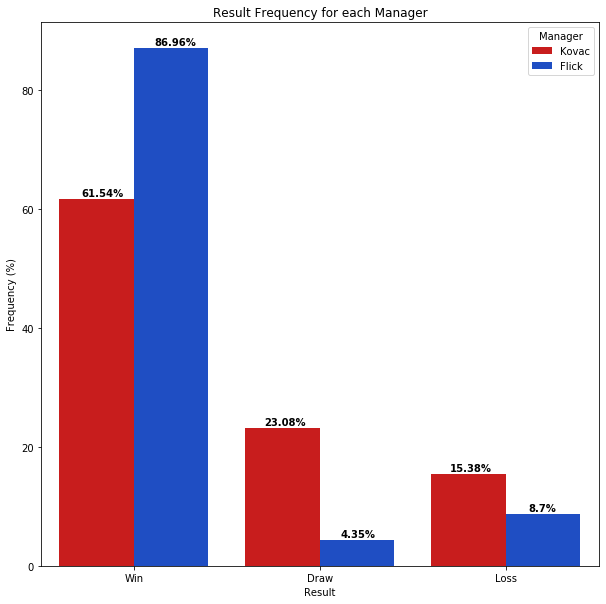

In [226]:
results_statsk = statsk.loc['mean',['Result_W','Result_D','Result_L']]*100
results_statsf = statsf.loc['mean',['Result_W','Result_D','Result_L']]*100
df = pd.DataFrame({'Result':['Win','Draw','Loss'],
                  'Kovac':results_statsk.values,
                  'Flick':results_statsf.values})
tidy = df.melt(id_vars='Result').rename(columns=str.title)
tidy.rename(columns={'Variable':'Manager','Value':'Frequency (%)'},inplace=True)
fig, ax = plt.subplots(figsize=(10,10))
colors = ['red','blue']
g = sns.barplot(x='Result',
            y='Frequency (%)',
            hue='Manager',
            palette=sns.xkcd_palette(colors),
            data=tidy)
g.set_title('Result Frequency for each Manager')
inds = [-0.28,0.7,1.7, 0.11, 1.11,2.12]
for i in range(tidy.shape[0]):
    g.text(inds[i],tidy.iloc[i,2]+0.5,'{}%'.format(round(tidy.iloc[i,2],2)),color='black',size='medium',weight='semibold')

Looking at the bar graph above, it is clear that Bayern Munich are winning much more frequently under Hansi Flick than under Niko Kovac. The team is also not settling for draws as frequently, decreasing their Draw rate by nearly 20%.

Now let's look at the average goals for and goals against for each manager, as well as their average xG and xGA:

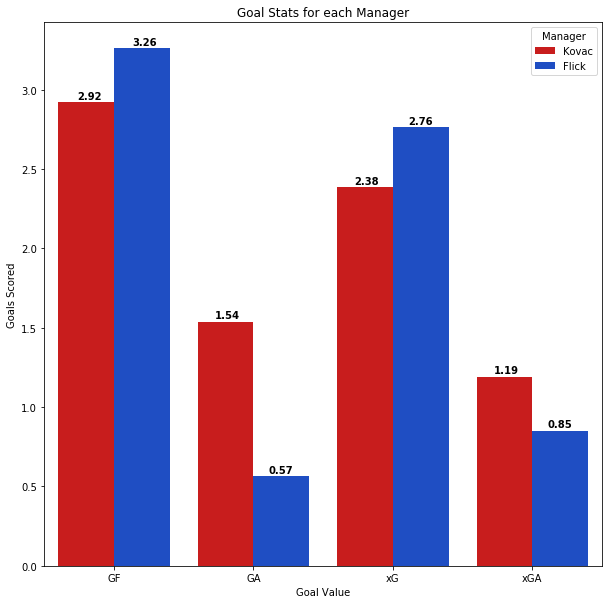

In [229]:
results_statsk = statsk.loc['mean',['GF','GA','xG','xGA']]
results_statsf = statsf.loc['mean',['GF','GA','xG','xGA']]
df = pd.DataFrame({'Goal Value':['GF','GA','xG','xGA'],
                  'Kovac':results_statsk.values,
                  'Flick':results_statsf.values})
tidy = df.melt(id_vars='Goal Value').rename(columns=str.title)
tidy.rename(columns={'Variable':'Manager','Value':'Goals Scored'},inplace=True)
fig, ax = plt.subplots(figsize=(10,10))
colors = ['red','blue']
g = sns.barplot(x='Goal Value',
            y='Goals Scored',
            hue='Manager',
            palette=sns.xkcd_palette(colors),
            data=tidy)
g.set_title('Goal Stats for each Manager')
inds = [-0.26,0.72,1.72,2.72, 0.13, 1.11,2.11,3.11]
for i in range(tidy.shape[0]):
    g.text(inds[i],tidy.iloc[i,2]+0.02,'{}'.format(round(tidy.iloc[i,2],2)),color='black',size='medium',weight='semibold')

Goals for and goals against averages can be found above, and Flick's Bayern improves in all four metrics shown. Both the team's GF and xG increase by nearly half a goal, and while the xGA has decreased by nearly half a goal, the team has actually been conceding nearly one goal less per match. 

### Percent Changes in Stats

Next we're going to quickly look over how the mean of each statistic has changed from having Kovac as manager to Flick. The highest positive percent changes are shown below:

In [155]:
stats_change = round((statsf-statsk)/statsk*100,2).loc['mean',:].sort_values(ascending=False)
stats_change.iloc[4:24].to_frame().rename(columns={'mean':'mean change (%)'})

,mean change (%)
Clean Sheets,163.77
GK Actions Outside Penalty Area,148.70
Offsides,83.70
ShortPass_Cmp,70.37
Formation_4-1-4-1,69.57
Dribbles to Shot,69.57
Headed Passes,55.94
Dribbles Leading to Goal,55.43
Launches_Cmp,48.48
ShortPass_Att,45.65


The biggest change is the number of clean sheets per game, with a 163% increase. The defense has dramatically improved under Hansi Flick as we saw with the decreased goals allowed earlier, and the number of clean sheets per game is also a reflection of that. Here are some other takeaways:

* Bayern are doing more short passes per game, as seen by the 70% increase in completed short passes and 45% increase in attempted short passes

* Bayern are pressing a lot higher up the pitch, as seen by the 39% increase in pressures and 32% increase in tackles in the attacking third

* Bayern are also not afraid to dribble to create shot opportunities, with a 69% increase in dribbles leading to a shot and a 55% increase in dribbles leading to a goal.

Let's look at the largest negative changes:

In [156]:
stats_change.iloc[-21:-1].to_frame().rename(columns={'mean':'mean change (%)'})

,mean change (%)
Clearances,-28.63
Saves,-30.43
non-penalty G-xG,-30.92
G-xG,-31.37
FK Shots,-36.41
SoTA,-39.44
GK Cross Stopped%,-42.77
PKs Made,-43.48
Result_L,-43.48
PKatt,-43.48


The biggest change was the post-shot xG-GA, which is the difference between the xG once an opponent's shot has been made and the actual goals against. This normally tracks how lucky or how able a goalkeeper can stop shots so this does not go in Flick's favor, but this is also dependent on how many shots the team gives up as well. Here are some other takeaways:

* The fact that the amount of draws and GA are some of the biggest negative changes goes to show how dramatic of a change this team has gone through midseason.

* Both G-xG and non-penalty G-xG decrease by about 30%, but we've seen that both Goals For and xG have increased during Flick's tenure. This goes to show that Bayern are not only scoring more, but are scoring now at the rate they are expected to with their play.

* Opponents of Bayern are not getting as many chances to score, as seen by the 46% decrease in Post-Shot xG and 39% decrease in opponent's shots on target.

We'll keep all of this in mind as the decision trees are built and see if these trends are still consistent.

## Decision Trees

To build the decision trees, a random forest algorithm from scikit-learn will be used. This will be able to make multiple decision trees to see the different statistics that are useful in distinguishing a match managed by Kovac and a match managed by Flick. 5 different decision trees will be made, with a max tree depth set to 3.

We'll first add a 'Manager' column to the dataset. The value in this column will be 0 if Niko Kovac was the manager and 1 if Hansi Flick was the manager.

In [157]:
ts['Manager'] = 0
ts.loc['2019-08-16':'2019-11-03','Manager'] = 0
ts.loc['2019-11-03':,'Manager'] = 1
ts.head()

,Comp,Venue,GF,GA,Opponent,xG,xGA,Poss,Result_D,Result_L,...,Fouls Committed,Fouls Drawn,PKwon,PKcon,Own Goals Conceded,Loose Balls Recovered,Aerial Duels Won,Aerial Duels Lost,Aerial Duels Won%,Manager
Date,,,,,,,,,,,,,,,,,,,,,
2019-08-16,Bundesliga,Home,2.0,2.0,Hertha BSC,2.7,0.9,71.0,1,0,...,6.0,18.0,1.0,0.0,0.0,88.0,14.0,9.0,60.9,0
2019-08-24,Bundesliga,Away,3.0,0.0,Schalke 04,1.6,0.9,66.0,0,0,...,10.0,11.0,1.0,0.0,0.0,82.0,13.0,10.0,56.5,0
2019-08-31,Bundesliga,Home,6.0,1.0,Mainz 05,2.6,0.4,67.0,0,0,...,16.0,12.0,0.0,0.0,0.0,82.0,14.0,15.0,48.3,0
2019-09-14,Bundesliga,Away,1.0,1.0,RB Leipzig,1.5,1.6,68.0,1,0,...,4.0,11.0,0.0,1.0,0.0,101.0,14.0,7.0,66.7,0
2019-09-18,Champions Lg,Home,3.0,0.0,rs Red Star,3.6,0.2,72.0,0,0,...,10.0,6.0,0.0,0.0,0.0,106.0,10.0,9.0,52.6,0


The data is divided into a feature set and a target vector:

In [158]:
X = ts.iloc[:,:-1].copy()
y = ts.iloc[:,-1].copy()
print('Feature matrix dimensions: {}'.format(X.shape))
print('Target vector length: {}'.format(y.shape))

Feature matrix dimensions: (36, 159)
Target vector length: (36,)


Finally, we're going to drop the 'Comp', 'Venue', and 'Opponent' columns from this dataset since the random forest algorithm cannot use these categorical features:

In [159]:
X.drop(['Comp','Venue','Opponent'],axis=1,inplace=True)

We're ready to use the Random Forest algorithm. We'll print out a confusion matrix to see how well the algorithm works:

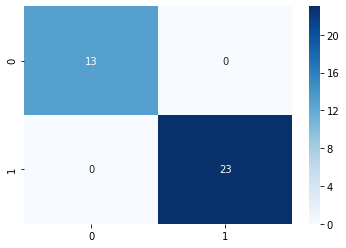

In [162]:
rforest = RandomForestClassifier(n_estimators=5,max_depth=3, random_state=9)
rforest.fit(X,y)
yfor_predict = rforest.predict(X)

cm = confusion_matrix(y, yfor_predict)
sns.heatmap(cm,annot=True,cmap='Blues')

The algorithm correctly predicts all 36 matches in our dataset! Each tree takes a slightly different approach, so let's go through each one to see how it split the data:

### Decision Tree 1: Progressive Passing

[Text(342.40909090909093, 713.475, 'Prog Passes <= 55.5\nentropy = 0.475\nsamples = 24\nvalue = [14, 22]\nclass = Flick'),
 Text(152.1818181818182, 509.625, 'Launches_Att <= 18.0\nentropy = 0.298\nsamples = 6\nvalue = [9, 2]\nclass = Kovac'),
 Text(76.0909090909091, 305.775, 'entropy = 0.0\nsamples = 5\nvalue = [9, 0]\nclass = Kovac'),
 Text(228.27272727272728, 305.775, 'entropy = 0.0\nsamples = 1\nvalue = [0, 2]\nclass = Flick'),
 Text(532.6363636363636, 509.625, 'Dribbles Contested <= 10.5\nentropy = 0.32\nsamples = 18\nvalue = [5, 20]\nclass = Flick'),
 Text(380.4545454545455, 305.775, 'ShortPass_Att <= 17.0\nentropy = 0.32\nsamples = 4\nvalue = [4, 1]\nclass = Kovac'),
 Text(304.3636363636364, 101.92499999999995, 'entropy = 0.0\nsamples = 1\nvalue = [0, 1]\nclass = Flick'),
 Text(456.54545454545456, 101.92499999999995, 'entropy = 0.0\nsamples = 3\nvalue = [4, 0]\nclass = Kovac'),
 Text(684.8181818181819, 305.775, 'MedPass_Att <= 590.0\nentropy = 0.095\nsamples = 14\nvalue = [1, 19]

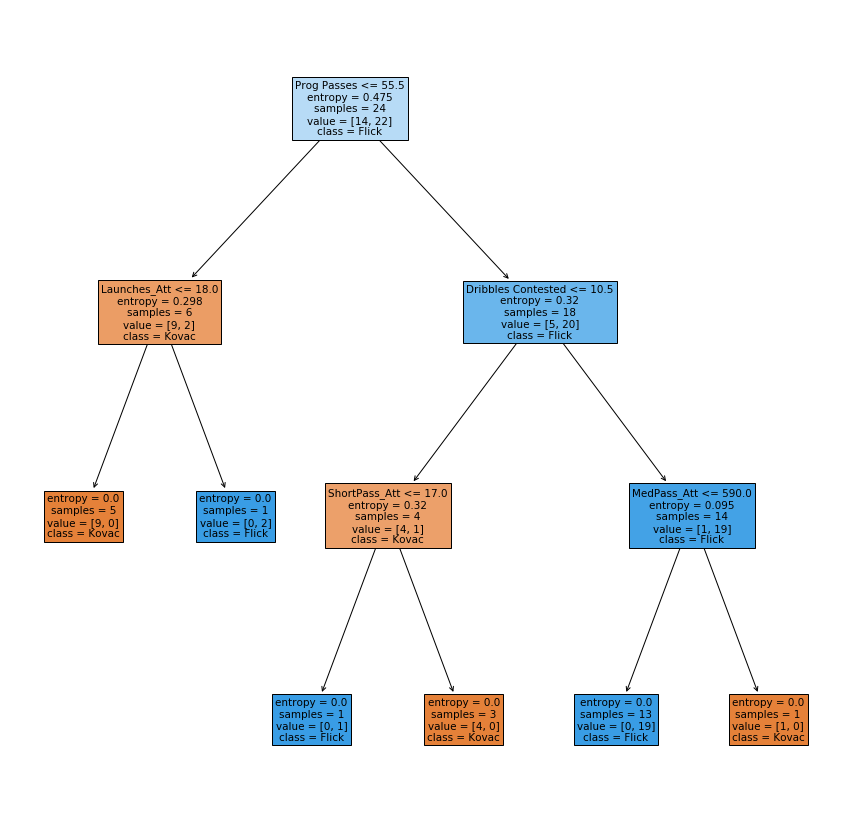

In [164]:
fn = X.columns
cn = ['Kovac', 'Flick']
fig, axes = plt.subplots(1,1,figsize=(15,15))
tree.plot_tree(rforest.estimators_[0],feature_names=fn,class_names=cn,filled=True)

The first tree first splits the data by progressive passes, with the greater amount being Flick matches. The matches with more progressive passes is then split based on dribbles contested, with more attempts being classified as Flick matches. Finally, launches attempted, short pass attempted, and medium passes attempted are used to split 1 anomaly from each of the remaining nodes. This tree tells us that:

1) **Flick's team passes the ball much more forward during matches.** This is one of the biggest things that can be noticed during Bayern matches. The team does not waste time passing the ball around; they will go right up the pitch and be in the final third as soon as they can.

2) **Bayern are a lot more aggressive defensively when an opponent is carrying the ball.** Bayern have world class defenders and they're now given the green light to challenge opponents for the ball without sitting back. The percentage of successful contested dribbles may not have changed, but they are attempting it more frequently.


### Decision Tree 2: Pressing Higher up the Pitch

[Text(483.59999999999997, 618.3449999999999, 'Pressures Att_3rd <= 44.5\nentropy = 0.444\nsamples = 20\nvalue = [12, 24]\nclass = Flick'),
 Text(362.7, 441.67499999999995, 'Nutmegs <= 0.5\nentropy = 0.375\nsamples = 9\nvalue = [12, 4]\nclass = Kovac'),
 Text(241.79999999999998, 265.005, 'Blocked Passes <= 12.5\nentropy = 0.32\nsamples = 4\nvalue = [1, 4]\nclass = Flick'),
 Text(120.89999999999999, 88.33500000000004, 'entropy = 0.0\nsamples = 3\nvalue = [0, 4]\nclass = Flick'),
 Text(362.7, 88.33500000000004, 'entropy = 0.0\nsamples = 1\nvalue = [1, 0]\nclass = Kovac'),
 Text(483.59999999999997, 265.005, 'entropy = 0.0\nsamples = 5\nvalue = [11, 0]\nclass = Kovac'),
 Text(604.5, 441.67499999999995, 'entropy = 0.0\nsamples = 11\nvalue = [0, 20]\nclass = Flick')]

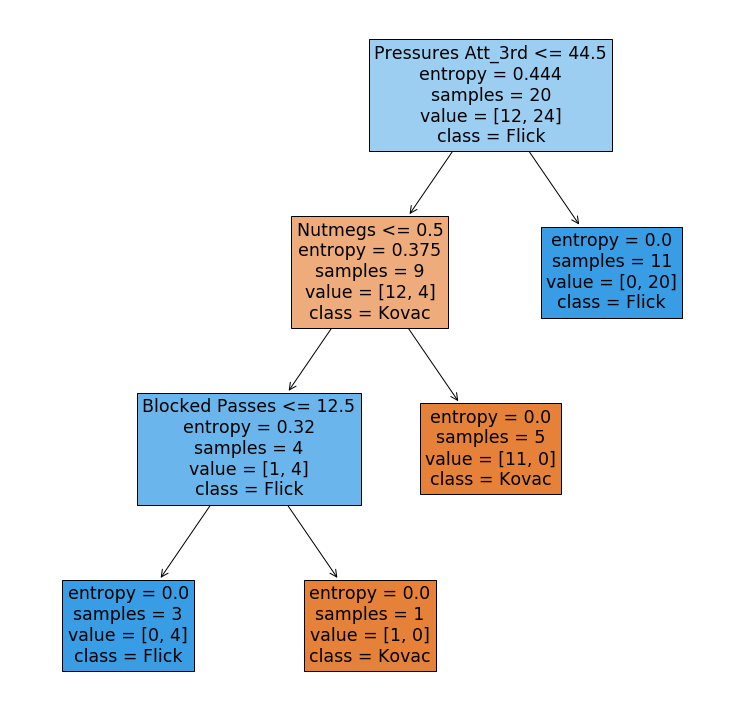

In [165]:
fig, axes = plt.subplots(1,1,figsize=(13,13))
tree.plot_tree(rforest.estimators_[1],feature_names=fn,class_names=cn,filled=True)

The second tree first splits the data based on pressures in their own attacking third, with all the matches with more than 44.5 pressures being matches managed by Flick. The next split is based on how many nutmegs the team commits in a match, and finally the amount of blocked passes splits the last anomaly from the remainder of the dataset. The main takeaway from this tree is that **Bayern are pressuring their opponents a lot higher up the pitch.** This is also very noticeable during matches, as Bayern are not sitting back in their defensive shape as often, and are more willing to try to take the ball back as soon as they lose it.


### Decision Tree 3: Being Efficient in Front of Goal

[Text(362.69999999999993, 618.3449999999999, 'Passes OOB <= 6.5\nentropy = 0.401\nsamples = 23\nvalue = [10, 26]\nclass = Flick'),
 Text(145.07999999999998, 441.67499999999995, 'G-xG <= 1.45\nentropy = 0.346\nsamples = 6\nvalue = [7, 2]\nclass = Kovac'),
 Text(72.53999999999999, 265.005, 'entropy = 0.0\nsamples = 3\nvalue = [6, 0]\nclass = Kovac'),
 Text(217.61999999999998, 265.005, 'Live Passes <= 561.5\nentropy = 0.444\nsamples = 3\nvalue = [1, 2]\nclass = Flick'),
 Text(145.07999999999998, 88.33500000000004, 'entropy = 0.0\nsamples = 1\nvalue = [1, 0]\nclass = Kovac'),
 Text(290.15999999999997, 88.33500000000004, 'entropy = 0.0\nsamples = 2\nvalue = [0, 2]\nclass = Flick'),
 Text(580.3199999999999, 441.67499999999995, 'Fouls leading to goal <= 0.5\nentropy = 0.198\nsamples = 17\nvalue = [3, 24]\nclass = Flick'),
 Text(507.78, 265.005, 'Crosses <= 18.5\nentropy = 0.077\nsamples = 15\nvalue = [1, 24]\nclass = Flick'),
 Text(435.23999999999995, 88.33500000000004, 'entropy = 0.0\nsample

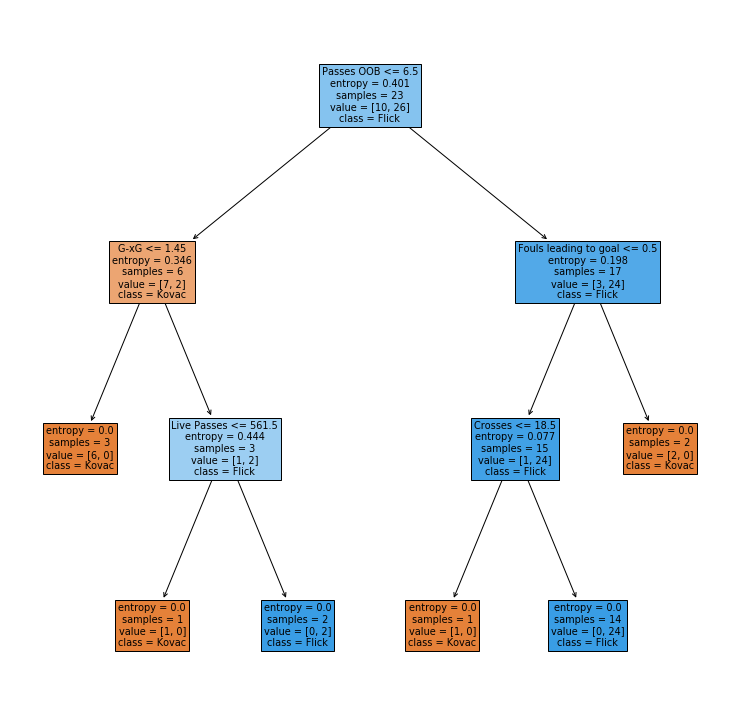

In [166]:
fig, axes = plt.subplots(1,1,figsize=(13,13))
tree.plot_tree(rforest.estimators_[2],feature_names=fn,class_names=cn,filled=True)

The first node splits based on passes that end up out of bounds, with less than 6.5 passes normally being Kovac matches. Those games are then split based on the difference between goals for and xG, with less than 1.45 being all Kovac matches. The other matches are then split on the amount of fouls committed leading to a goal, where if it doesn't happen at all, it is probably a match managed by Flick. The more passes out of bounds per game does not bode well for Hansi Flick's side, but a key takeaway from this tree is that **Bayern are scoring more than their xG predicts them to be under Flick.** Bayern are clinically finishing shots as of late, and that really helps if they are not playing the best they can in a given match.


### Decision Tree 4: Switching Play more Frequently

[Text(511.5, 951.3000000000001, 'Low Passes <= 88.0\nentropy = 0.494\nsamples = 22\nvalue = [16, 20]\nclass = Flick'),
 Text(279.0, 679.5, 'Shots lead to another shot <= 0.5\nentropy = 0.32\nsamples = 7\nvalue = [12, 3]\nclass = Kovac'),
 Text(186.0, 407.70000000000005, 'Passes Intercepted <= 10.5\nentropy = 0.375\nsamples = 2\nvalue = [1, 3]\nclass = Flick'),
 Text(93.0, 135.89999999999998, 'entropy = 0.0\nsamples = 1\nvalue = [0, 3]\nclass = Flick'),
 Text(279.0, 135.89999999999998, 'entropy = 0.0\nsamples = 1\nvalue = [1, 0]\nclass = Kovac'),
 Text(372.0, 407.70000000000005, 'entropy = 0.0\nsamples = 5\nvalue = [11, 0]\nclass = Kovac'),
 Text(744.0, 679.5, 'Crosses <= 21.5\nentropy = 0.308\nsamples = 15\nvalue = [4, 17]\nclass = Flick'),
 Text(558.0, 407.70000000000005, 'Dispossessed <= 16.0\nentropy = 0.48\nsamples = 4\nvalue = [3, 2]\nclass = Kovac'),
 Text(465.0, 135.89999999999998, 'entropy = 0.0\nsamples = 2\nvalue = [3, 0]\nclass = Kovac'),
 Text(651.0, 135.89999999999998, 'en

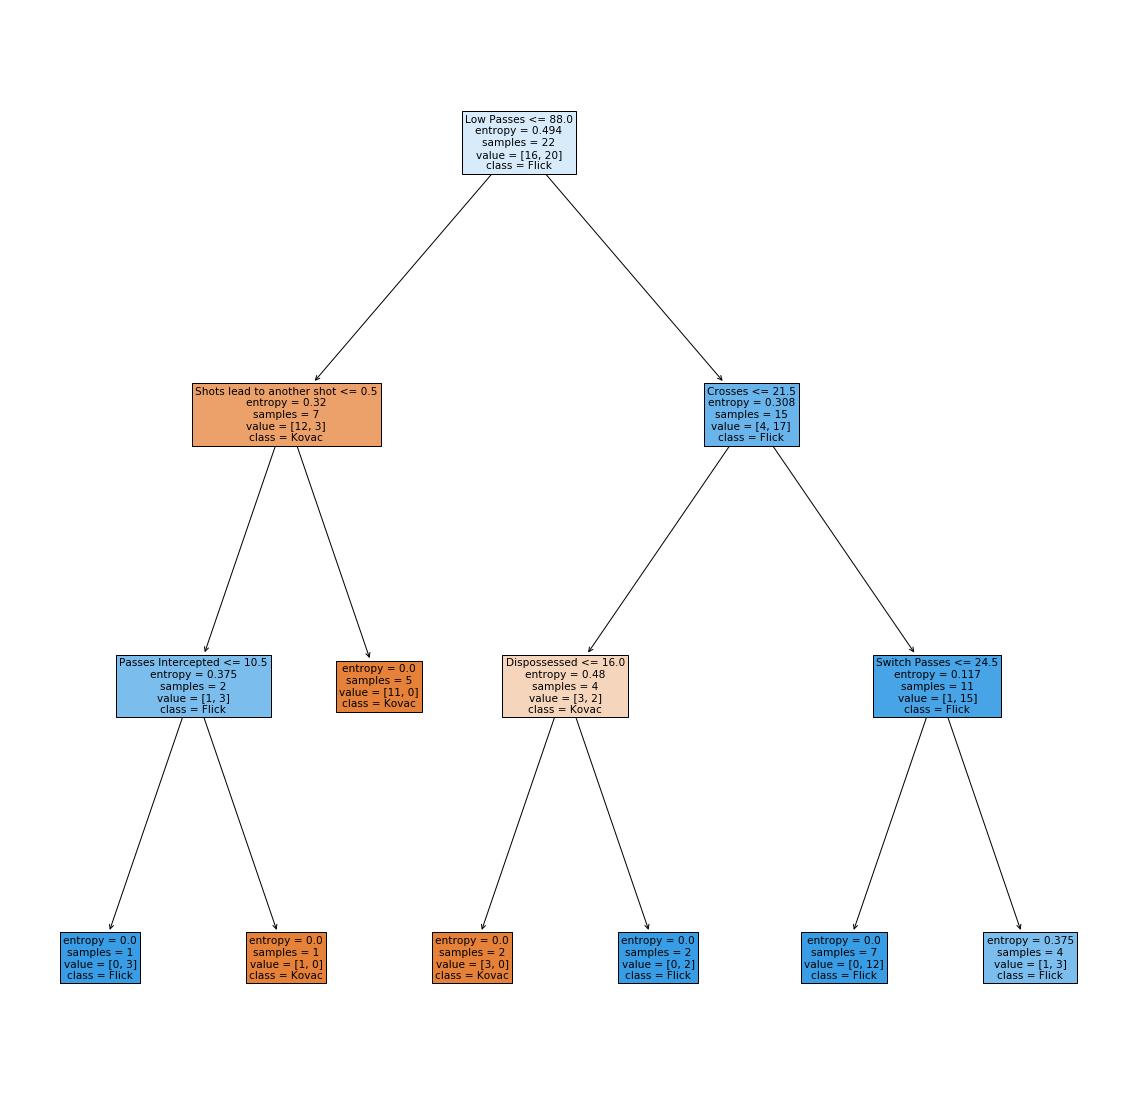

In [167]:
fig, axes = plt.subplots(1,1,figsize=(20,20))
tree.plot_tree(rforest.estimators_[3],feature_names=fn,class_names=cn,filled=True)

This tree took a while to split up the data. The first split is based on low passes per game (which are passes of low aerial trajectory, not ground passes), with more per game being mostly Flick matches. The next depth uses 'shots leading to another shot' and crosses to split the data. Finally, the number of passes intercepted, the number of times dispossessed, and the number of switch passes are used to split the remainder of the data. Here are the main takeaways from this tree:

1) **Flick's Bayern is making more low passses, crosses, and switch passes.** This relates to Flick's Bayern passing more in general. Although this doesn't say whether they are more successful with their passes or not, being able to pass more means that they either have the ball more than normal or that they actually are more successful with their passes so that can pass more.

2) **Kovac's Bayern had more shots that lead to other shots.** This is a tough one to interpret. On one hand, this can be interpreted as Kovac's side being able to make more chances in the way of shooting. On the other hand, we've seen that Flick's side is better at scoring goals and xG. There are plenty of ways to create more shots, and it seems that Kovac's side had more of their chances based on other shots.


### Decision Tree 5: Not Wasting Time Building from the Back

[Text(483.59999999999997, 618.3449999999999, 'Touches Def_3rd <= 265.5\nentropy = 0.461\nsamples = 22\nvalue = [13, 23]\nclass = Flick'),
 Text(362.7, 441.67499999999995, 'Goal Kicks Launch% <= 15.5\nentropy = 0.358\nsamples = 20\nvalue = [7, 23]\nclass = Flick'),
 Text(241.79999999999998, 265.005, 'Dribbles to Shot <= 1.5\nentropy = 0.463\nsamples = 8\nvalue = [7, 4]\nclass = Kovac'),
 Text(120.89999999999999, 88.33500000000004, 'entropy = 0.0\nsamples = 4\nvalue = [7, 0]\nclass = Kovac'),
 Text(362.7, 88.33500000000004, 'entropy = 0.0\nsamples = 4\nvalue = [0, 4]\nclass = Flick'),
 Text(483.59999999999997, 265.005, 'entropy = 0.0\nsamples = 12\nvalue = [0, 19]\nclass = Flick'),
 Text(604.5, 441.67499999999995, 'entropy = 0.0\nsamples = 2\nvalue = [6, 0]\nclass = Kovac')]

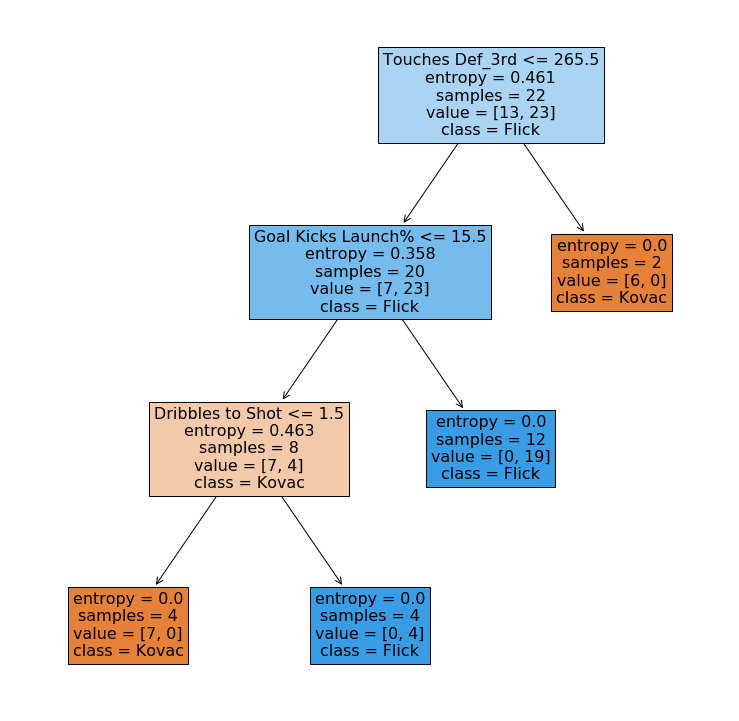

In [168]:
fig, axes = plt.subplots(1,1,figsize=(13,13))
tree.plot_tree(rforest.estimators_[4],feature_names=fn,class_names=cn,filled=True)

The first node splits based on the amount of touches the team has in the defensive third, with less touches being more likely to be a Flick match. The next split is based on the percentage of goal kicks Manuel Neuer decides to launch, with higher than 15.5% always being a Flick match. The last split is based on the number of dribbles leading to a shot, with less than 1.5 always being a Kovac match based on the remaining data.

The less touches in the defensive third and the more goal kicks being launched are consistent with the results we saw from other trees: Hansi Flick's Bayern want to get up the pitch and are less willing to build up from the back. More progressive passes per game means that less touches during the game will be in the defensive third, and that is evident from the results in these trees.

## Conclusions

Let's review some of the insights we gained from this analysis:

1) Bayern are winning much more frequently under Hansi Flick, and they have improved their Goals For and Goals Against as well as their xG and xGA all within a season.

2) Bayern are more direct with their attacks under Hansi Flick. They are taking less touches in the defensive third and have signficantly increased their progressive passes per game. 

3) Instead of immediately falling into their defensive shape when they lose the ball, Bayern are pressing a lot higher up the pitch. The amount of pressures and tackles in the attacking third have significantly increased, and this helps them continue their high-powered attacks.

4) Pressing high up the pitch and giving themselves more opportunities to have the ball also allows Bayern to pass the ball more often. The amount of short passes, low passes, crosses, and switch passes have all increased under Hansi Flick, allowing the team to move the ball around more and create more goal scoring opportunities.

The Champions League restarts in August, with Bayern still having to play their 2nd leg match against Chelsea. But with the way they are playing under their new manager, you would not be crazy to predict that Bayern have a good chance at winning their first UCL title since 2013.